# Unsupervised Experiment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle, islice

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# Set up methods' colors
methods_colors = {
    "oracle": "#70FF00",
    "avg_ens": "#FF7133", #FF7133 -> FF9664 (lighter)
    "best_ms": "#33D4FF",
    "detectors": "#CCCCCC",
    "feature_based": "#91AAC2",
    "sit": "#FFB522",
    "conv": "#4494FF",
    "conv_2": "#0048FF",
    "rocket": "#EA7DFF", #B400FF -> D800FF -> EA7DFF(lighter)
    "best_ad_train": "#228B22",
    "worst_ad_test": "#8B0000",
}

# Get results data

Please select a measure for the analysis. You can choose between VUS_PR and AUC_PR. 

In [24]:
measure_name = 'VUS_PR'
test_size = 1
figure_path = '../../paper_submission_files/figures/{}.svg'

all_method_score = ['convnet_default_128_score',
             'resnet_default_1024_score',
             'rocket_128_score',
             'knn_1024_score',
             'sit_stem_original_512_score',
             'Avg Ens']

all_method_score_name = ['convnet',
             'resnet',
             'rocket',
             'knn',
             'sit_stem',
             'Avg Ens']

In [4]:
def read_df(measure_name,test_size,split_number):
    df = pd.read_csv('../../results/unsupervised_results/{}/testsize_{}_split_{}.csv'.format(measure_name,test_size,split_number))
    df = df.rename(columns={'Unnamed: 0':'filename'})
    df = df.set_index('filename')
    return df

In [5]:
all_length = [16, 32, 64, 128, 256, 512, 768, 1024]

template_names = {
    'inception_time_{}': 'InceptTime-{}',
    'convnet_{}': 'ConvNet-{}',
    'resnet_{}': 'ResNet-{}',
    'sit_conv_{}': 'SiT-conv-{}',
    'sit_linear_{}': 'SiT-linear-{}',
    'sit_stem_{}': 'SiT-stem-{}',
    'sit_stem_relu_{}': 'SiT-stem-ReLU-{}',
    'rocket_{}': 'Rocket-{}',
    'ada_boost_{}': 'AdaBoost-{}',
    'knn_{}': 'kNN-{}',
    'decision_tree_{}': 'DecisionTree-{}',
    'random_forest_{}': 'RandomForest-{}',
    'mlp_{}': 'MLP-{}',
    'bayes_{}': 'Bayes-{}',
    'qda_{}': 'QDA-{}',
    'svc_linear_{}': 'SVC-{}',
    'IFOREST': 'IForest',
    'LOF': 'LOF',
    'MP': 'MP',
    'NORMA': 'NormA',
    'IFOREST1': 'IForest1',
    'HBOS': 'HBOS',
    'OCSVM': 'OCSVM',
    'PCA': 'PCA',
    'AE': 'AE',
    'CNN': 'CNN',
    'LSTM': 'LSTM',
    'POLY': 'POLY',
    'Avg Ens': 'Avg Ens',
    'Oracle': 'Oracle',
    'best_ms': 'Best MS',
    'VUS_PR': 'VUS-PR',
    'label': 'Label',
    'best_ms': 'Best MS',
    'convnet': "ConvNet",
    'resnet': "ResNet",
    'rocket': "Rocket",
    'knn': "kNN",
    'sit_stem': "SiT-stem",
}

final_names = {}
for length in all_length:
    for key, value in template_names.items():
        if '{}' in key:
            new_key = key.format(length)
            new_value = value.format(length)
            final_names[new_key] = new_value
        else:
            final_names[key] = value

## Overall results

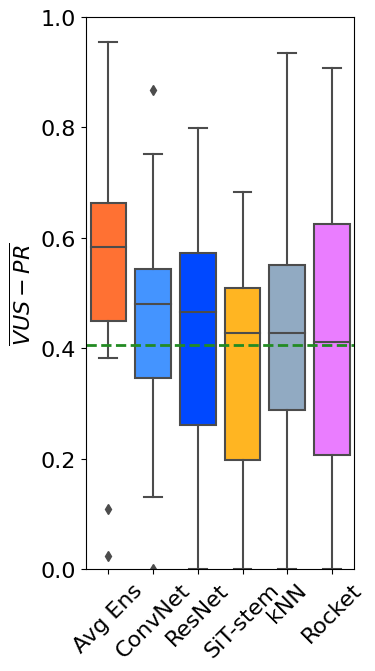

In [27]:
all_dataset = []
all_methods = None
for split_number in range(16):
    df = read_df(measure_name, test_size, split_number)
    all_dataset.append(df.index[0].split('/')[0])
    all_methods = list(df[all_method_score + ['Oracle', 'best_ad_train', 'worst_ad_test']].mean().index)

df_transfer_res = pd.DataFrame(index=all_dataset, columns=all_methods)
for split_number in range(16):
    df = read_df(measure_name, test_size, split_number)
    for method in all_methods:
        df_transfer_res.at[df.index[0].split('/')[0], method] = df[method].mean()

df_to_plot = df_transfer_res[all_method_score].subtract(df_transfer_res['worst_ad_test'], axis=0).div(df_transfer_res['Oracle'] - df_transfer_res['worst_ad_test'], axis=0)

order = list(df_to_plot.median().sort_values().index)[::-1]

plt.rcParams.update({'font.size': 16})

my_pal = {"Avg Ens": methods_colors["avg_ens"], "convnet_default_128_score": methods_colors["conv"], "resnet_default_1024_score": methods_colors["conv_2"], 'knn_1024_score': methods_colors["feature_based"], 'rocket_128_score': methods_colors["rocket"], 'sit_stem_original_512_score': methods_colors["sit"]}
names_graph = [final_names[x] for x in ['Avg Ens', 'convnet', 'resnet', 'sit_stem', 'knn', 'rocket']]

plt.figure(figsize=(4, 7))
sns.boxplot(df_to_plot, order=order, palette=my_pal, saturation=1)
plt.xticks(list(range(len(names_graph))), names_graph, rotation=45)
plt.ylim(0, 1)
plt.ylabel(r"$\overline{" + final_names[measure_name] + "}$")

plt.axhline(df_transfer_res['best_ad_train'].subtract(df_transfer_res['worst_ad_test'], axis=0).div(df_transfer_res['Oracle'] - df_transfer_res['worst_ad_test'], axis=0).mean(), linestyle='--', linewidth=2, color=methods_colors['best_ad_train'])

plt.tight_layout()
plt.savefig(figure_path.format("11_one_vs_all_1"))
plt.show()
plt.close()

## Trained on 15 datasets, tested on 1

Here we train the methods on 15 datasets and test on one dataset (not seem in the train)

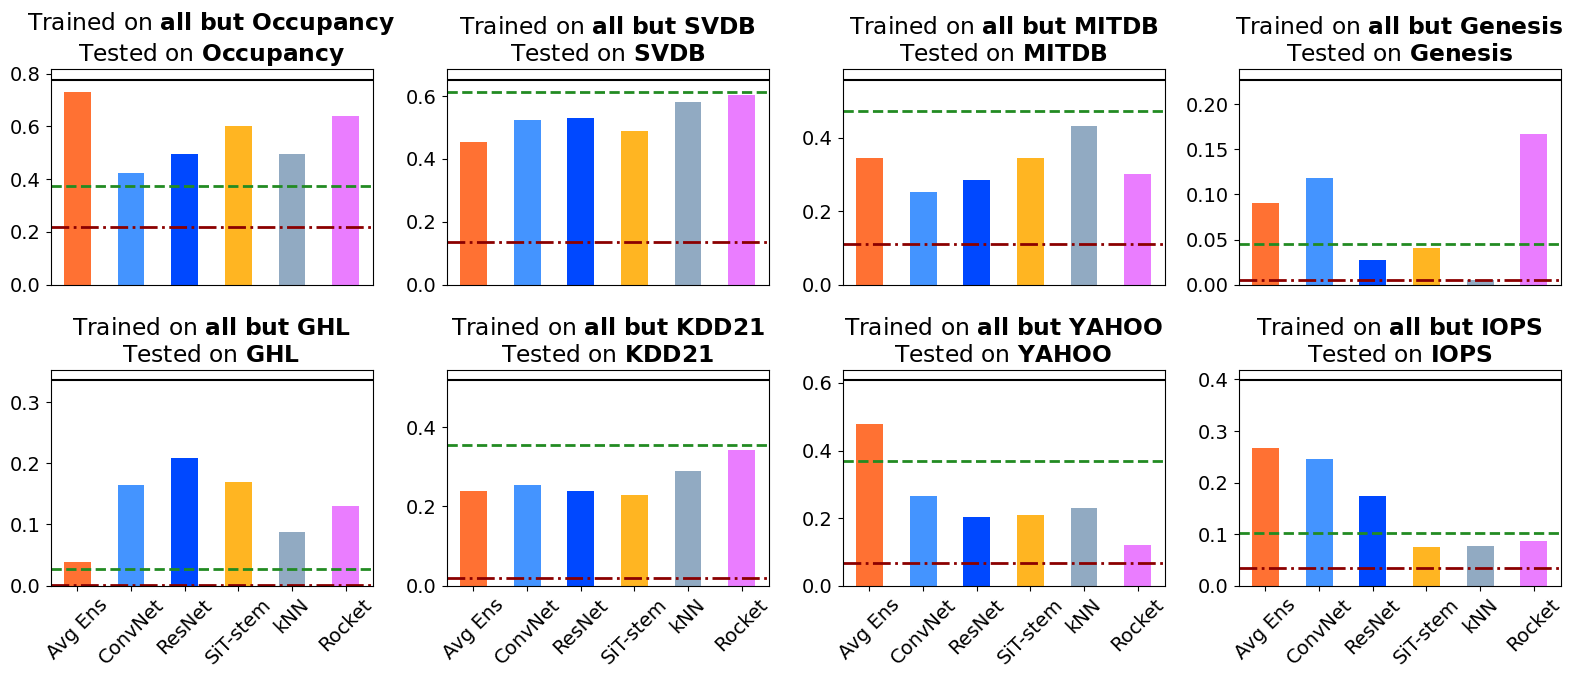

In [28]:
plt.rcParams.update({'font.size': 14})

curr_names = ['Avg Ens', 'convnet', 'resnet', 'sit_stem', 'knn', 'rocket']
n_col = 4
n_row = 2
fig,  axes = plt.subplots(nrows=n_row,  ncols=n_col, figsize=(16, 7))
curr_dataset = ['Occupancy', 'SVDB', 'MITDB', 'Genesis', 'GHL', 'KDD21', 'YAHOO', 'IOPS']

for i, dataset in enumerate(curr_dataset):
    my_colors = list(islice(cycle([methods_colors['avg_ens'],  methods_colors['conv'], methods_colors['conv_2'], methods_colors['sit'], methods_colors['feature_based'], methods_colors['rocket']]), None, len(df_transfer_res[all_method_score].loc[dataset])))
    df_transfer_res[order].loc[dataset].plot(kind='bar', ax=axes[i//n_col, i%n_col], color=my_colors)
    axes[i//n_col, i%n_col].axhline(df_transfer_res['Oracle'].loc[dataset], linestyle='-', color='k')
    axes[i//n_col, i%n_col].axhline(df_transfer_res['best_ad_train'].loc[dataset], linestyle='--', linewidth=2, color=methods_colors['best_ad_train'])
    axes[i//n_col, i%n_col].axhline(df_transfer_res['worst_ad_test'].loc[dataset], linestyle='dashdot', linewidth=2, color=methods_colors['worst_ad_test'])
    axes[i//n_col, i%n_col].set_title(r"Trained on $\bf{all\ but\ " + dataset + "}$" + '\n' + r"Tested on $\bf{" + dataset + "}$" )
    if i//n_col == 1: 
        axes[i//n_col, i%n_col].set_xticks(range(len(all_method_score)), [final_names[x] for x in curr_names], rotation=45)
    else:
        axes[i//n_col, i%n_col].set_xticks([])

plt.tight_layout()
plt.savefig(figure_path.format("11_one_vs_all_2"))
plt.show()
plt.close()